In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from glob import glob
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from joblib import Parallel, delayed

from matplotlib.font_manager import FontProperties

# from simulate_radiances_utils import *
%run simulate_radiances_utils.py
import urllib 

In [5]:
all_times = pd.date_range(start = '2011-01-01 1:30:00',
                          end = '2016-01-01 1:30:00',
                          freq = '3H')

In [6]:
data_dir =  '/net/fluo/data2/groupMembers/cchristo/'
raw_aeri_data_dir = data_dir + 'aeri/aeri_noise_filtered/summit/'
# filename_format = ''

In [7]:
file_paths = sorted(os.listdir(raw_aeri_data_dir))

In [80]:
ds_i = xr.open_dataset(raw_aeri_data_dir + file_paths[300])
ds_i_time = ds_i.isel(time = 0)

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [38]:
# for var_name in ds_i.variables:
#     try:
#         print(var_name +  ' : ' + ds_i[var_name].attrs['longname'])
#     except: 
#         pass

In [187]:
# ds_i['sceneMirrorPosition']

<xarray.DataArray 'sceneMirrorPosition' (time: 3352)>
array([83., 84., 85., ..., 88., 89., 90.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-04-17T00:03:42 ... 2011-04-17T23:56:32
Attributes:
    longname:   Instrument scene mirror position identifier
    units:      count
    precision:  1E0

In [89]:
# file_paths_sub = [raw_aeri_data_dir + fname for fname in file_paths if '201507' in fname]

file_paths_sub = [raw_aeri_data_dir + fname for fname in file_paths]

In [53]:
# len(file_paths_sub)

In [40]:
ds_1 = xr.open_dataset(file_paths_sub[0])
ds_2 = xr.open_dataset(file_paths_sub[0])
# ds_i_time = ds_i.isel(time = 0)

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [116]:
def preprocess_spectra_ds(ds):
    try:
#         time_offset = ds['time_offset']
        time_offset = ds['Time_UTC_hours']
        ds_subset = ds['mean_rad'].to_dataset()
        ds_subset = ds_subset.assign_coords({'time':time_offset})
    except: 
        print('Failed')
    return ds_subset

In [166]:
# %%capture
# ds_i = xr.open_mfdataset(file_paths_sub, 
#                          combine = 'by_coords',
#                          concat_dim = 'time', 
#                          preprocess=preprocess_spectra_ds)

In [119]:
%%capture
rad_threshold_800 = 29.0

failed_times = []
failed_reason = []

rad_values_800 = np.zeros(all_times.shape)
cloud_free_bool = np.zeros(all_times.shape)

for time_ii in range(len(all_times)):
# for time_ii in range(9000, 9001):
    try:
        
        time_i = all_times[time_ii]
        print(time_i)
    #     search_str = str(time_i.year) + str(time_i.month) + str(time_i.day)
        search_str = '{year}{month:02d}{day:02d}'.format(year = time_i.year,
                                                        month = time_i.month,
                                                        day = time_i.day)
        file_path_to_open = [raw_aeri_data_dir + fname for fname in file_paths if \
                             (search_str in fname) & ('ch2' not in fname)]
        file_path_to_open = file_path_to_open[0]

        ds_i = preprocess_spectra_ds(xr.open_dataset(file_path_to_open))
    #     ds_i = xr.open_dataset(file_path_to_open)

        # find index of closest spectum
        time_argmin = np.argmin(abs(np.datetime64(time_i) - ds_i['time']))

        ds_i_closest = ds_i.isel(time = time_argmin)

        # set missing values (-9999) to nan
        ds_i_closest = ds_i_closest.where(ds_i_closest >= 0, np.nan)

        # compute mean radiance in 800cm band
        mean_rad_800 = compute_mean_rad_800_band(ds_i_closest['mean_rad'].values,
                              nu = ds_i_closest['wnum'].values)
        rad_values_800[time_ii] = mean_rad_800
        if mean_rad_800 <= rad_threshold_800:
            cloud_free_bool[time_ii] = True
        else: 
            cloud_free_bool[time_ii] = False
    except Exception as e:
        print('Failed on ', time_i)
        failed_times.append(time_i)
        failed_reason.append(str(e))

In [77]:
failed_reason

["ufunc 'absolute' did not contain a loop with signature matching types dtype('<M8[ns]') -> dtype('<M8[ns]')"]

In [81]:
np.datetime64(time_i) - ds_i['time']

<xarray.DataArray 'time' (time: 3352)>
array(['2014-01-30T01:30:00.000000000', '2014-01-30T01:29:59.999999000',
       '2014-01-30T01:29:59.999998000', ...,
       '2014-01-30T01:29:59.996651000', '2014-01-30T01:29:59.996650000',
       '2014-01-30T01:29:59.996649000'], dtype='datetime64[ns]')
Dimensions without coordinates: time

In [82]:
np.datetime64(time_i)

numpy.datetime64('2014-01-30T01:30:00.000000')

In [84]:
ds_i

<xarray.Dataset>
Dimensions:   (time: 3352, wnum: 2714)
Coordinates:
  * wnum      (wnum) float64 491.8 492.3 492.8 ... 1.799e+03 1.799e+03 1.8e+03
Dimensions without coordinates: time
Data variables:
    mean_rad  (time, wnum) float64 ...

In [85]:
rr = xr.open_dataset(file_path_to_open)

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [93]:
# rr
# rr['Time_UTC_hours']

In [88]:
time_i

Timestamp('2014-01-30 01:30:00', freq='3H')

In [71]:
# search_str
all_times[9000]

Timestamp('2014-01-30 01:30:00', freq='3H')

(array([733773., 734138., 734503., 734869., 735234., 735599., 735964.]),
 <a list of 7 Text major ticklabel objects>)

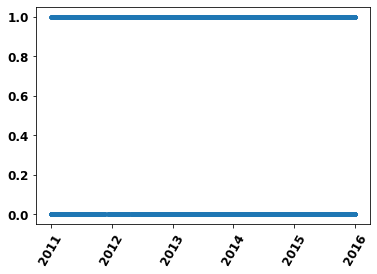

In [120]:
# plt.plot(cloud_free_bool)
plt.plot(all_times, cloud_free_bool, '.')
plt.xticks(rotation = 60)

In [123]:
# rad_values_800[63]
np.count_nonzero(cloud_free_bool)/len(cloud_free_bool)

0.6083236361147238

(array([734138., 734152., 734169., 734183., 734197., 734211., 734228.,
        734242., 734258.]),
 <a list of 9 Text major ticklabel objects>)

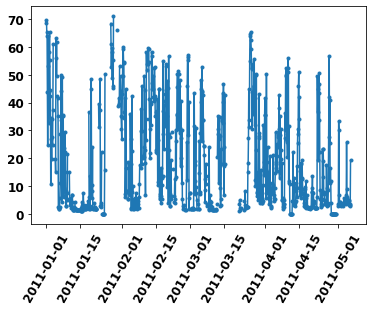

In [124]:
cut_ind = 1000
plt.plot(all_times[:cut_ind], rad_values_800[:cut_ind], '.-')
plt.xticks(rotation = 60)
# plt.xlim([2011, 2012])

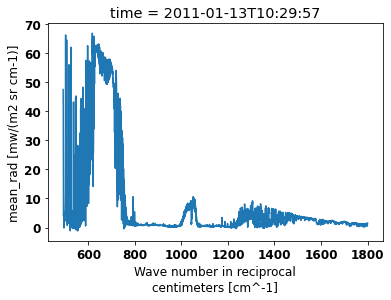

In [278]:
ds_i_closest['mean_rad'].plot()

## Look at a single day

In [66]:
ds_i_nan = ds_i.where(ds_i > 0, np.nan)
ds_i_time_max = ds_i_nan.max('time')
ds_i_time_min = ds_i_nan.min('time')
ds_i_time_median = ds_i_nan.median('time')

/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/cchristo/anaconda3/envs/rad_transfer/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


28.169071204050436


Text(0.5, 1.0, 'Downwelling Thermal Radiance in Nadir at surface')

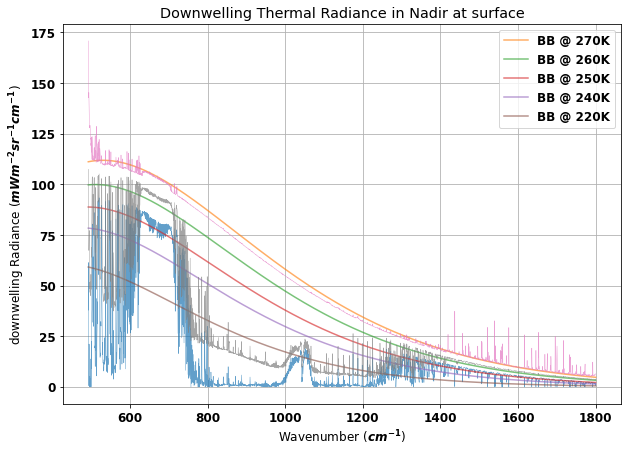

In [106]:
plt.figure(figsize = (10,7))
# ds_i
k_grid = ds_i_time['wnum'].values
rad = ds_i_time_min['mean_rad'].values
ds_i.isel(time = 0)
plt.plot(k_grid, rad, linewidth = 0.5, alpha=0.7)



wavenum_m = k_grid*1e2
W_m_mW_cm = 1e2*1e3
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,270),label='BB @ 270K',alpha=0.63)
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,260),label='BB @ 260K',alpha=0.63)
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,250),label='BB @ 250K',alpha=0.63)
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,240),label='BB @ 240K',alpha=0.63)
plt.plot(k_grid, W_m_mW_cm*planck_wavenumber(wavenum_m,220),label='BB @ 220K',alpha=0.63)
plt.legend(loc=0)

k_grid = ds_i_time['wnum'].values
rad = ds_i_time_max['mean_rad'].values
plt.plot(k_grid, rad, linewidth = 0.5,alpha=0.7)



k_grid = ds_i_time['wnum'].values
rad = ds_i_time_median['mean_rad'].values
plt.plot(k_grid, rad, linewidth = 0.5,alpha=0.7)


print(compute_mean_rad_800_band(rad,
                          nu = k_grid))

# plt.xlim((491,1799))
# plt.xlim((500, 1800))
# plt.xlim([790, 810])

plt.grid()
plt.xlabel('Wavenumber ($cm^{-1}$)')
plt.ylabel(r'downwelling Radiance ($mW m^{-2} sr^{-1} cm^{-1}$)')
plt.title('Downwelling Thermal Radiance in Nadir at surface')

In [226]:
compute_mean_rad_800_band(W_m_mW_cm*planck_wavenumber(wavenum_m,215),
                          nu = k_grid)

29.000542

In [228]:
# np.diff(k_grid)
compute_mean_rad_800_band(W_m_mW_cm*planck_wavenumber(wavenum_m,225),
                          nu = k_grid)

36.835754

In [140]:
standard_dev_rad = ds_i_time['standard_dev_mean_rad'].values
k_grid2 = ds_i_time['wnum2'].values

KeyError: 'standard_dev_mean_rad'

Text(0, 0.5, 'Radiance STD')

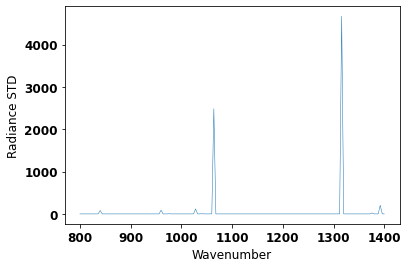

In [25]:
plt.plot(k_grid2, standard_dev_rad, linewidth = 0.5)

plt.xlabel('Wavenumber')
plt.ylabel('Radiance STD')